## Libraries

In [1]:
import os
import glob
from pathlib import Path
import random
from collections import Counter # contare (query sql)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.utils import plot_model

import librosa
from IPython.display import Audio

## Load dataset

### Dani

In [ ]:
# Montaggio di Google Drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from pathlib import Path

# possibili path (o hai il dataset su drive, o nella working directory)
drive_path = Path('/content/drive/MyDrive/music_dataset') # dani
local_path = Path('./music_dataset') # tommaso

# automaticamente scelgo path esistente
if drive_path.exists():
    DATA_PATH = drive_path
elif local_path.exists():
    DATA_PATH = local_path
else:
    raise FileNotFoundError(
        f"Nessun dataset trovato in {drive_path} né in {local_path}"
    )

# trovo filepaths (lista dei file .wav) e labels (le y)
filepaths = list(DATA_PATH.rglob('*.wav'))
labels = [p.parent.name for p in filepaths]

print(f"Trovati {len(filepaths)} file audio di {len(set(labels))} classi.")
print(f"Classi: {sorted(set(labels))}")

Trovati 42311 file audio di 28 classi.
Classi: ['Accordion', 'Acoustic_Guitar', 'Banjo', 'Bass_Guitar', 'Clarinet', 'Cymbals', 'Dobro', 'Drum_set', 'Electro_Guitar', 'Floor_Tom', 'Harmonica', 'Harmonium', 'Hi_Hats', 'Horn', 'Keyboard', 'Mandolin', 'Organ', 'Piano', 'Saxophone', 'Shakers', 'Tambourine', 'Trombone', 'Trumpet', 'Ukulele', 'Violin', 'cowbell', 'flute', 'vibraphone']


In [3]:
filepaths

[WindowsPath('music_dataset/Accordion/100.wav'),
 WindowsPath('music_dataset/Accordion/1000.wav'),
 WindowsPath('music_dataset/Accordion/1001.wav'),
 WindowsPath('music_dataset/Accordion/1002.wav'),
 WindowsPath('music_dataset/Accordion/1003.wav'),
 WindowsPath('music_dataset/Accordion/1004.wav'),
 WindowsPath('music_dataset/Accordion/1005.wav'),
 WindowsPath('music_dataset/Accordion/1006.wav'),
 WindowsPath('music_dataset/Accordion/1007.wav'),
 WindowsPath('music_dataset/Accordion/1008.wav'),
 WindowsPath('music_dataset/Accordion/1009.wav'),
 WindowsPath('music_dataset/Accordion/101.wav'),
 WindowsPath('music_dataset/Accordion/1010.wav'),
 WindowsPath('music_dataset/Accordion/1011.wav'),
 WindowsPath('music_dataset/Accordion/1012.wav'),
 WindowsPath('music_dataset/Accordion/1013.wav'),
 WindowsPath('music_dataset/Accordion/1014.wav'),
 WindowsPath('music_dataset/Accordion/1015.wav'),
 WindowsPath('music_dataset/Accordion/1016.wav'),
 WindowsPath('music_dataset/Accordion/1017.wav'),
 W

## Data Analysis

In [ ]:
from collections import Counter # hashmap utile

# Numero campioni audio per classe

counts = Counter(labels) # hashmap {classe:#esempi}

for classe, count in counts.items():
    print(f"{classe}: {count}")

# problema: class imbalance
# possiamo risolvere con oversampling delle classi con meno esempi, 
# o direttamente allenando le reti pesando le classi in base a quanti esempi hanno

Accordion: 3581
Acoustic_Guitar: 3654
Banjo: 2998
Bass_Guitar: 3613
Clarinet: 634
cowbell: 621
Cymbals: 208
Dobro: 487
Drum_set: 3648
Electro_Guitar: 1316
Floor_Tom: 406
flute: 3719
Harmonica: 131
Harmonium: 1314
Hi_Hats: 444
Horn: 1258
Keyboard: 2041
Mandolin: 2458
Organ: 1442
Piano: 575
Saxophone: 454
Shakers: 1357
Tambourine: 558
Trombone: 2965
Trumpet: 503
Ukulele: 790
vibraphone: 506
Violin: 630


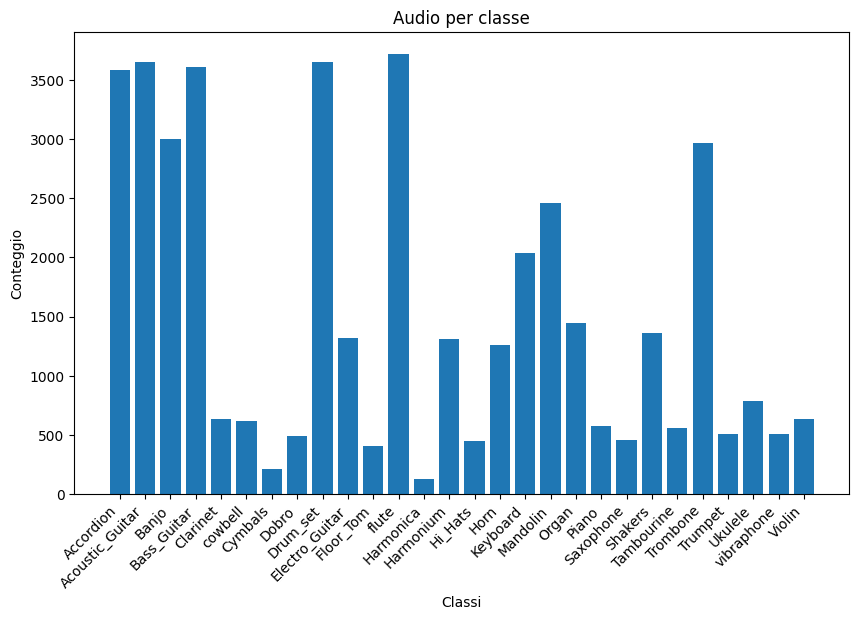

In [ ]:
# Plot numero di audio per classe

plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values())
plt.title('Audio per classe')
plt.xlabel('Classi')
plt.ylabel('Conteggio')
plt.xticks(rotation=45, ha='right')
plt.show()

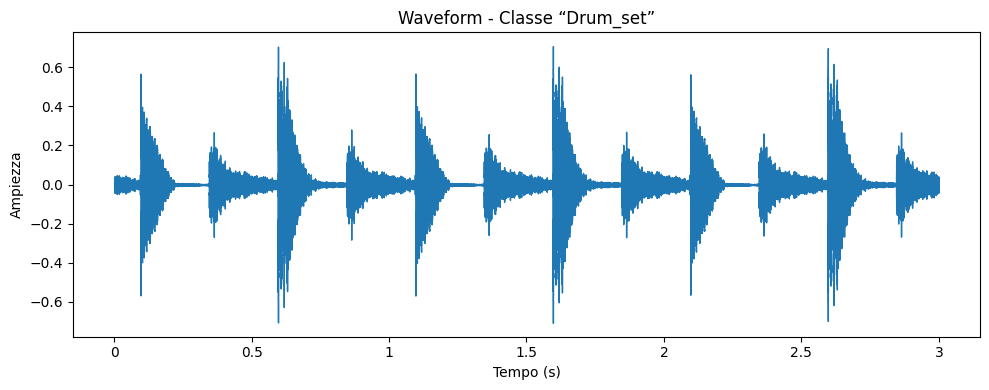

In [83]:
# prendo audio random, visualizziamo waveform e lo ascoltiamo

idx = random.randint(0,len(filepaths)) # indice random
sample_path = filepaths[idx] # audio
sample_label = labels[idx] # label

y, sr = librosa.load(sample_path, sr=None) # load audio
display(Audio(y, rate=sr)) # ascolto

# plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - Classe “{sample_label}”")
plt.xlabel("Tempo (s)")
plt.ylabel("Ampiezza")
plt.tight_layout()
plt.show()

In [72]:
# prova che tutti i file hanno dirata 3s

durations = [librosa.get_duration(path=f) for f in filepaths]
print("Min dur:", np.min(durations))
print("Max dur:", np.max(durations))
print("Mean dur:", np.mean(durations))

Min dur: 3.0
Max dur: 3.0
Mean dur: 3.0


## Prendo un mini-dataset del dataset (per fare test veloci)

In [ ]:
import random

SEED = 69 # nice
random.seed(SEED)
np.random.seed(SEED)

N = 100 # Numero esempi per classe

mini_filepaths = []
mini_labels    = []

for cls in classes:
    cls_files = [f for f, lab in zip(filepaths, labels) if lab == cls] # Tutti i file di quella classe
    sampled = random.sample(cls_files, k=min(N, len(cls_files))) # Seleziono N file a caso
    mini_filepaths.extend(sampled)
    mini_labels.extend([cls] * len(sampled))

print(f"Totale file audio del mini-dataset: {len(mini_filepaths)}")

Totale file audio del mini-dataset: 2800


In [ ]:
# uso il mini-dataset
filepaths = mini_filepaths
labels = mini_labels

## CONTINUARE DA QUA

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

filepaths, labels = shuffle(filepaths, labels, random_state=SEED) # shuffle filepaths e labels, mantenendo il mapping tra loro

# Suddividi in train/test (ad esempio 80/20)
fp_train, fp_test, y_train, y_test = train_test_split(mini_filepaths, mini_labels, test_size=0.2, stratify=mini_labels, random_state=SEED)

print(f"Train: {len(fp_train)}  Test: {len(fp_test)}")

Train: 2240  Test: 560


In [51]:
import librosa

# to-do
def extract_mfcc(path, n_mfcc=13):
    """
    Carica un file WAV e restituisce un vettore di dimensione n_mfcc
    corrispondente ai MFCC medi su tutti i frame.
    """
    y, sr = librosa.load(path, sr=None, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)

In [ ]:
# Estrae MFCC per train e test
X_train = np.array([extract_mfcc(fp) for fp in fp_train])
X_test  = np.array([extract_mfcc(fp) for fp in fp_test])

# Verifica shapes
print("X_train shape:", X_train.shape)  # (n_train, 13)
print("X_test shape:", X_test.shape)   # (n_test, 13)

# N.B.: ci mette 27s se ho solo 100 immagini per classe

X_train shape: (2240, 13)
X_test shape: (560, 13)


In [53]:
import tensorflow as tf

print("✅ TensorFlow version:", tf.__version__)
print("🖥️ GPU rilevate:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ La GPU è attiva e disponibile! 🚀")
else:
    print("❌ Nessuna GPU disponibile.")

✅ TensorFlow version: 2.10.1
🖥️ GPU rilevate: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ La GPU è attiva e disponibile! 🚀


## Models

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=2000) # modello stupido solo per testare
clf.fit(X_train, y_train)

c:\Users\tomma\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000)

### Results

In [55]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7678571428571429

Classification Report:
                  precision    recall  f1-score   support

      Accordion       0.50      0.45      0.47        20
Acoustic_Guitar       0.81      0.65      0.72        20
          Banjo       0.64      0.70      0.67        20
    Bass_Guitar       1.00      1.00      1.00        20
       Clarinet       0.65      0.75      0.70        20
        Cymbals       0.53      0.40      0.46        20
          Dobro       0.81      0.85      0.83        20
       Drum_set       0.91      1.00      0.95        20
 Electro_Guitar       0.89      0.80      0.84        20
      Floor_Tom       0.67      0.90      0.77        20
      Harmonica       0.85      0.85      0.85        20
      Harmonium       1.00      0.95      0.97        20
        Hi_Hats       0.72      0.65      0.68        20
           Horn       0.95      1.00      0.98        20
       Keyboard       0.80      1.00      0.89        20
       Mandolin       0.67      0

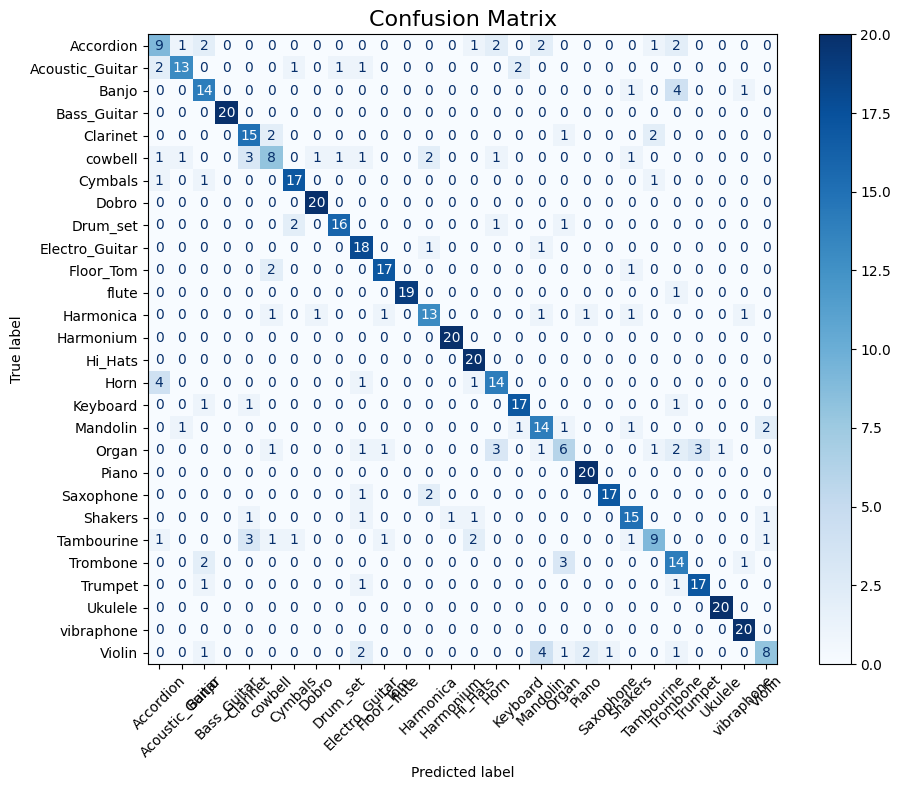

In [56]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45, values_format='d') # metto labels diagonali cosi non si sovrappongono

ax.set_title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()